In [31]:
import pandas as pd
import numpy as np

In [32]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [35]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

In [36]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

In [37]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.88      0.88      6159
   Tiene Alto Valor Adquisitivo       0.63      0.62      0.62      1982

                       accuracy                           0.82      8141
                      macro avg       0.75      0.75      0.75      8141
                   weighted avg       0.82      0.82      0.82      8141



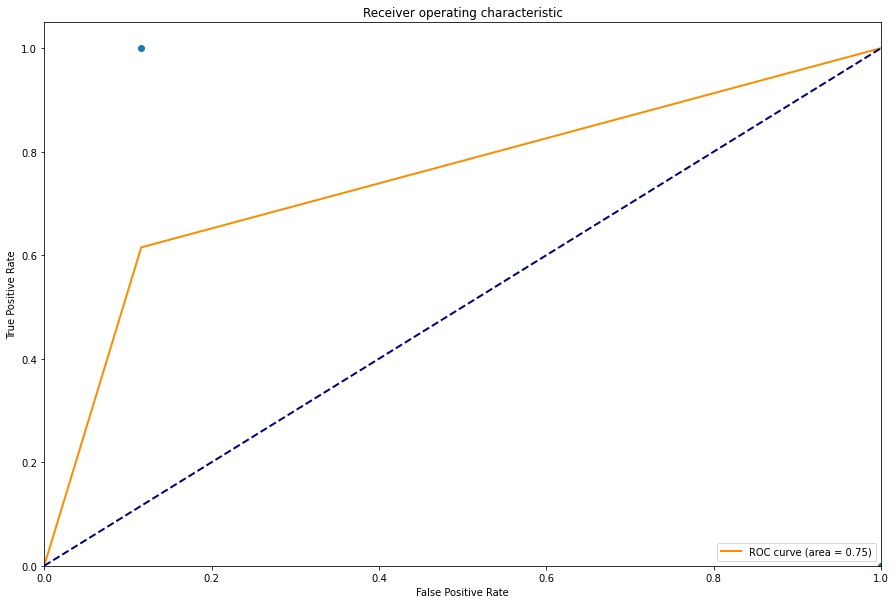

0.7495537037428429

In [38]:
arbol = DecisionTreeClassifier()
arbol.fit(X_train, y_train)
y_pred = arbol.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred)

In [52]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    y_array=np.array(y)    
    for criterio in ['gini','entropy']:
        for profundidad_maxima in [1,2,3,4,5,6,7,8,9,10,15,20,25]: 
            kf = StratifiedKFold(n_splits=5)
            metricas_de_la_combinacion = []
            for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
                print(profundidad_maxima)
                arbol = DecisionTreeClassifier(criterion = criterio, max_depth = profundidad_maxima,min_samples_leaf = 1000)
                arbol.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = arbol.predict(X.iloc[test_index])
                metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
                print(roc_auc_score(y.iloc[test_index], y_pred))

            print(f"Promedio de la combinación: {np.mean(metricas_de_la_combinacion)}")
            metrics.append((criterio, profundidad_maxima, np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['criterio', 'profundidad maxima', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [53]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)
print(mejor_combinacion)

1
0.5
1
0.5
1
0.5
1
0.5
1
0.5
Promedio de la combinación: 0.5
2
0.6691692655639917
2
0.6789769912819497
2
0.6828427366092067
2
0.6869654415164124
2
0.6811472161680207
Promedio de la combinación: 0.6798203302279162
3
0.6691692655639917
3
0.6789769912819497
3
0.6828427366092067
3
0.6869654415164124
3
0.6811472161680207
Promedio de la combinación: 0.6798203302279162
4
0.7310311434529444
4
0.6789769912819497
4
0.6828427366092067
4
0.6869654415164124
4
0.6811472161680207
Promedio de la combinación: 0.6921927058057067
5
0.7310311434529444
5
0.7366793804900601
5
0.7473189518525856
5
0.7453448005415759
5
0.7499948401690774
Promedio de la combinación: 0.7420738233012487
6
0.7310311434529444
6
0.7366793804900601
6
0.7229944769169805
6
0.7453448005415759
6
0.7499948401690774
Promedio de la combinación: 0.7372089283141277
7
0.7310311434529444
7
0.7366793804900601
7
0.7229944769169805
7
0.7453448005415759
7
0.7499948401690774
Promedio de la combinación: 0.7372089283141277
8
0.7310311434529444
8
0.7

In [45]:
parametros_arbol = mejor_combinacion.loc[:].values[0]
arbol = DecisionTreeClassifier(criterion = parametros_arbol[0], max_depth = parametros_arbol[1])
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.76      1.00      0.86      6159
   Tiene Alto Valor Adquisitivo       0.00      0.00      0.00      1982

                       accuracy                           0.76      8141
                      macro avg       0.38      0.50      0.43      8141
                   weighted avg       0.57      0.76      0.65      8141



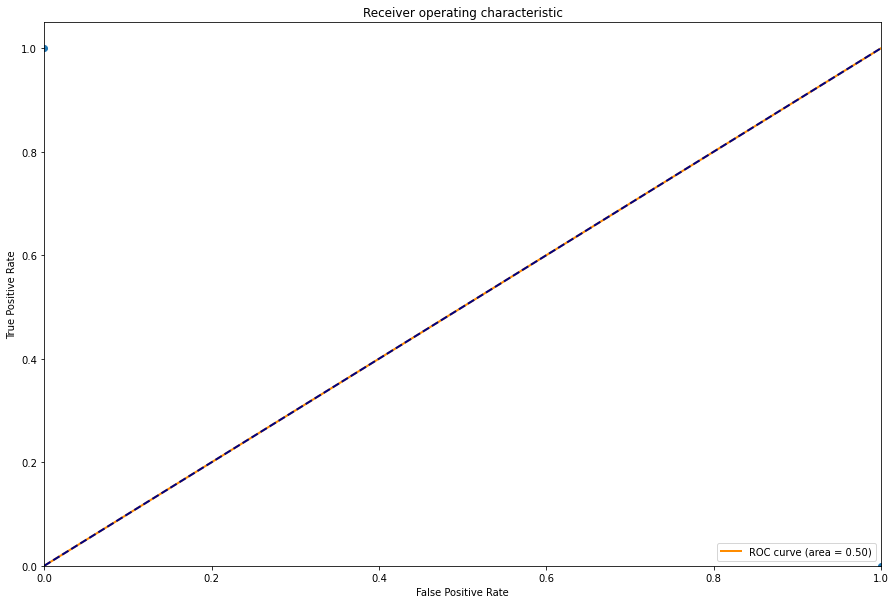

0.5

In [42]:
y_pred = arbol.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred)